# Lab. 6 - A glimpse of Neural Networks

In [24]:
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt

## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument.

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization

Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.

Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.

Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [25]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2

    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise

    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)

    return X, y

In [26]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()

    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)

    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [27]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

### Synthetic Example

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

In [28]:
# put your code here
Xtr, Ytr = generate_2d_cls_data(100, 0.3)
Xte, Yte = generate_2d_cls_data(100, 0.3)

In [32]:
# Build your first model by creating a Sequential object and then adding 2 Dense layers:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6684 - loss: 0.6397 - val_accuracy: 0.0000e+00 - val_loss: 0.9510
Epoch 2/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6189 - loss: 0.6132 - val_accuracy: 0.0000e+00 - val_loss: 0.9350
Epoch 3/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6524 - loss: 0.6057 - val_accuracy: 0.0000e+00 - val_loss: 0.9208
Epoch 4/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6669 - loss: 0.5920 - val_accuracy: 0.0000e+00 - val_loss: 0.9112
Epoch 5/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6565 - loss: 0.5873 - val_accuracy: 0.0000e+00 - val_loss: 0.9029
Epoch 6/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5760 - loss: 0.6147 - val_accuracy: 0.0000e+00 - val_loss: 0.8971
Epoch 7/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6684 - loss: 0.5997 - val_accuracy: 0.0000e+00 - val_loss: 0.8911
Epoch 8/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6050 - loss: 0.6072 - val_acc

#### Plot the results from the model

In [33]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


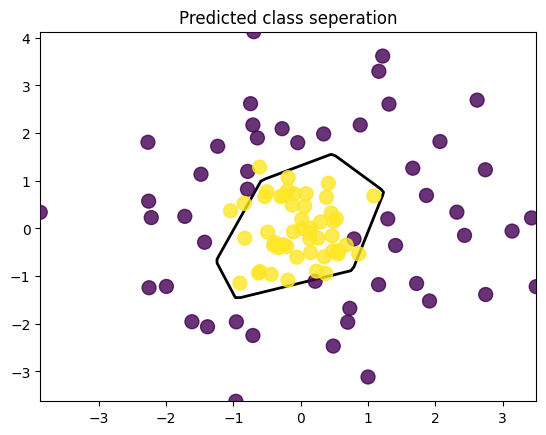

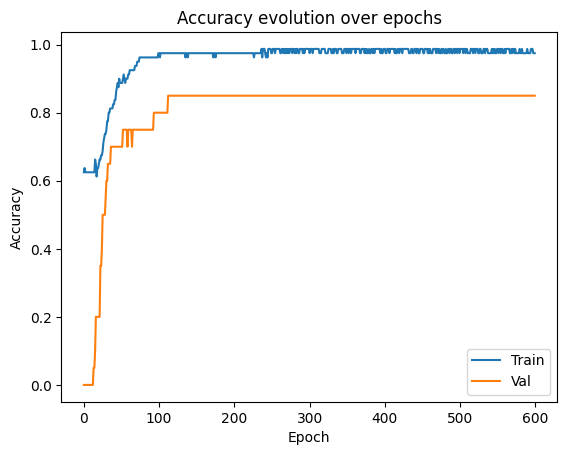

In [34]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with many (e.g. 100) neurons
 2. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).

Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### 1) NN with single layer with 100 neurons

In [35]:
# Build your first model by creating a Sequential object and then adding 1 Dense layers:
model = Sequential()

# Add layers
model.add(Dense(100, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Fit model
history = model.fit(
    Xtr, Ytr,
    epochs=500,
    batch_size=10,
    validation_split=0.2,
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3981 - loss: 0.7473 - val_accuracy: 0.0500 - val_loss: 0.7449
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6024 - loss: 0.6392 - val_accuracy: 0.0000e+00 - val_loss: 0.8104
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6292 - loss: 0.5901 - val_accuracy: 0.0000e+00 - val_loss: 0.8503
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5979 - loss: 0.5676 - val_accuracy: 0.0000e+00 - val_loss: 0.8750
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6290 - loss: 0.5203 - val_accuracy: 0.0000e+00 - val_loss: 0.8870
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6378 - loss: 0.5148 - val_accuracy: 0.0000e+00 - val_loss: 0.8924
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6254 - loss: 0.5080 - val_accuracy: 0.0000e+00 - val_loss: 0.8929
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5782 - loss: 0.5169 - val_accuracy: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


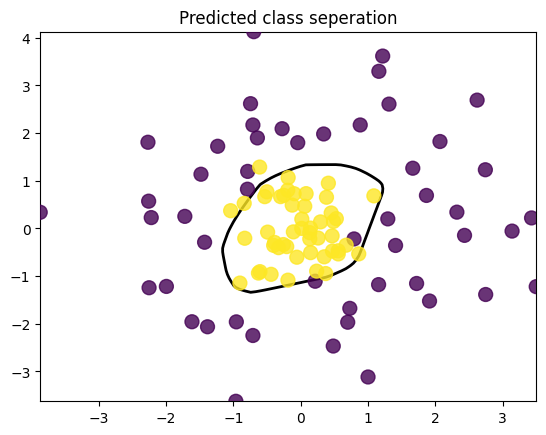

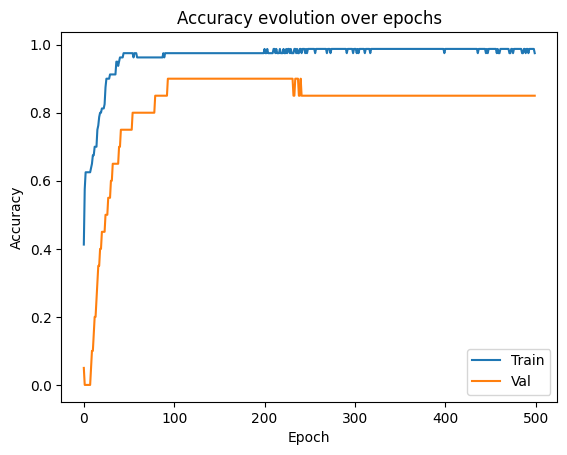

In [36]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

#### 2) NN with 4 hidden layer with  40 neurons

In [37]:
# Repeat the previous code but with 4 hidden layers with 40 neurons (in each layer)
model = Sequential()

model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    Xtr, Ytr,
    epochs=500,
    batch_size=10,
    validation_split=0.2,
)

train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5829 - loss: 0.6856 - val_accuracy: 0.0000e+00 - val_loss: 0.7548
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6014 - loss: 0.6442 - val_accuracy: 0.0000e+00 - val_loss: 0.8039
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6216 - loss: 0.6152 - val_accuracy: 0.0000e+00 - val_loss: 0.8397
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6437 - loss: 0.5841 - val_accuracy: 0.0000e+00 - val_loss: 0.8689
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7008 - loss: 0.5232 - val_accuracy: 0.0000e+00 - val_loss: 0.8787
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6523 - loss: 0.5296 - val_accuracy: 0.0000e+00 - val_loss: 0.8899
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6241 - loss: 0.5183 - val_accuracy: 0.0000e+00 - val_loss: 0.8933
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6233 - loss: 0.4943 - val_accurac

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


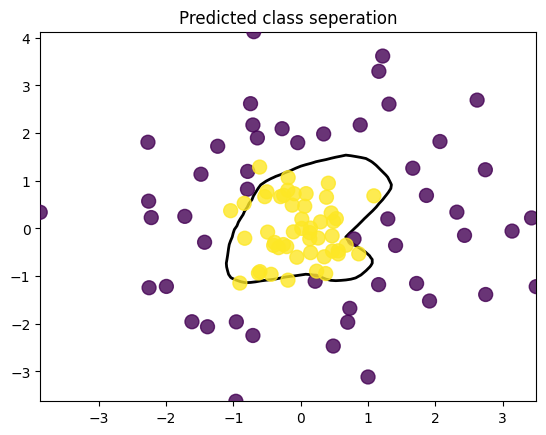

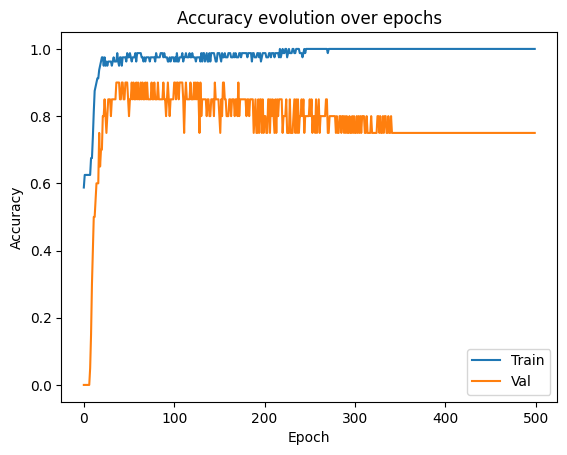

In [38]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

<h3>Comments</h3>

Both the models don't show signs of overfitting.
1. In this first setting the NN is
<br>
Training error: 6.00%, Test error: 15.00%
2. In the second setting,
<br>
Training error: 6.00%, Test error: 14.00%

The best model is therefore


## [Optional] Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.


## Load Data

In [ ]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [ ]:
# Pick two digits, later you can try with different pairs
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST.
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

We can visualize the images...

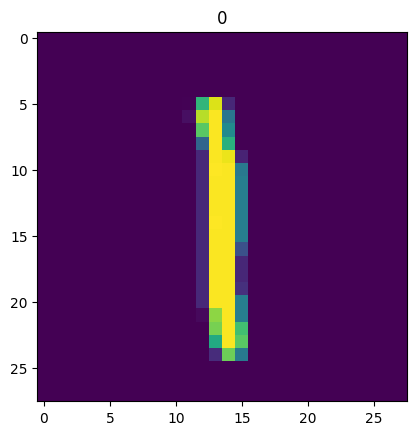

In [ ]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3]);

#### Define The Keras Model

Here you can play with the structure of the network, e.g. you may start from dense layers and then check what happens if you replace them with convolutional layers

In [ ]:
model = Sequential()
# Add hidden layers
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))

# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(1, activation='sigmoid'))

#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],)

#### Fit the model

In [ ]:
# fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,
    epochs=100,
    batch_size=10,
    validation_split=0.2,
)

Epoch 1/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9632 - loss: 0.9082 - val_accuracy: 0.9889 - val_loss: 0.2260
Epoch 2/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9920 - loss: 0.1269 - val_accuracy: 0.9962 - val_loss: 0.0370
Epoch 3/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9943 - loss: 0.0632 - val_accuracy: 0.9942 - val_loss: 0.0266
Epoch 4/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9951 - loss: 0.0315 - val_accuracy: 0.9958 - val_loss: 0.0252
Epoch 5/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9968 - loss: 0.0252 - val_accuracy: 0.9950 - val_loss: 0.0279
Epoch 6/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9960 - loss: 0.0216 - val_accuracy: 0.9900 - val_loss: 0.0893
Epoch 7/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9940 - loss: 0.0537 - val_accuracy: 0.9969 - val_loss: 0.0198
Epoch 8/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9971 - loss: 0

In [ ]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training error: 0.04%, Test error: 0.28%


In [ ]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.1279
Test accuracy: 99.72%


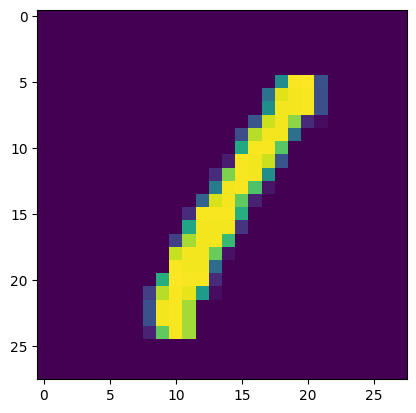

In [ ]:
# Plot training history
fig, ax = plt.subplots()
ax.imshow(Xtr[0].reshape(28, 28))

<h2>Convolutional layers</h3>

Epoch 1/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9708 - loss: 0.0701 - val_accuracy: 0.9962 - val_loss: 0.0107
Epoch 2/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9973 - val_loss: 0.0092
Epoch 3/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9976 - loss: 0.0075 - val_accuracy: 0.9981 - val_loss: 0.0062
Epoch 4/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 5/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9965 - val_loss: 0.0112
Epoch 6/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9988 - val_loss: 0.0047
Epoch 7/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9969 - val_loss: 0.0040
Epoch 8/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 

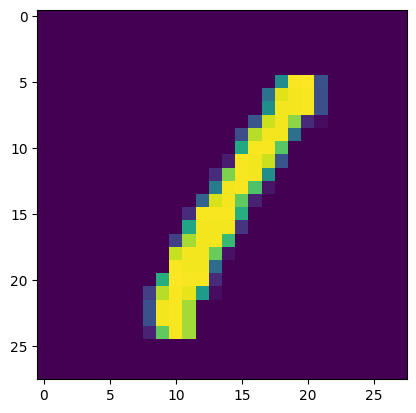

In [ ]:
num_1 = 1
num_2 = 7

Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

Xtr = Xtr / 255.0
Xts = Xts / 255.0
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

model = Sequential()

model.add(Conv2D(20, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(20, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],)

history = model.fit(
    Xtr, Ytr,
    epochs=100,
    batch_size=10,
    validation_split=0.2,
)

train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

fig, ax = plt.subplots()
ax.imshow(Xtr[0].reshape(28, 28))

<h3>Comparison</h3>
